In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np 
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import ExpectationMaximization
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/opt/anaconda3/envs/pgmpy310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets
X_with_y = X.copy()
X_with_y["Diabetes_binary"] = y.values

===== DATA SHAPE =====
(253680, 22)

===== DATA INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253

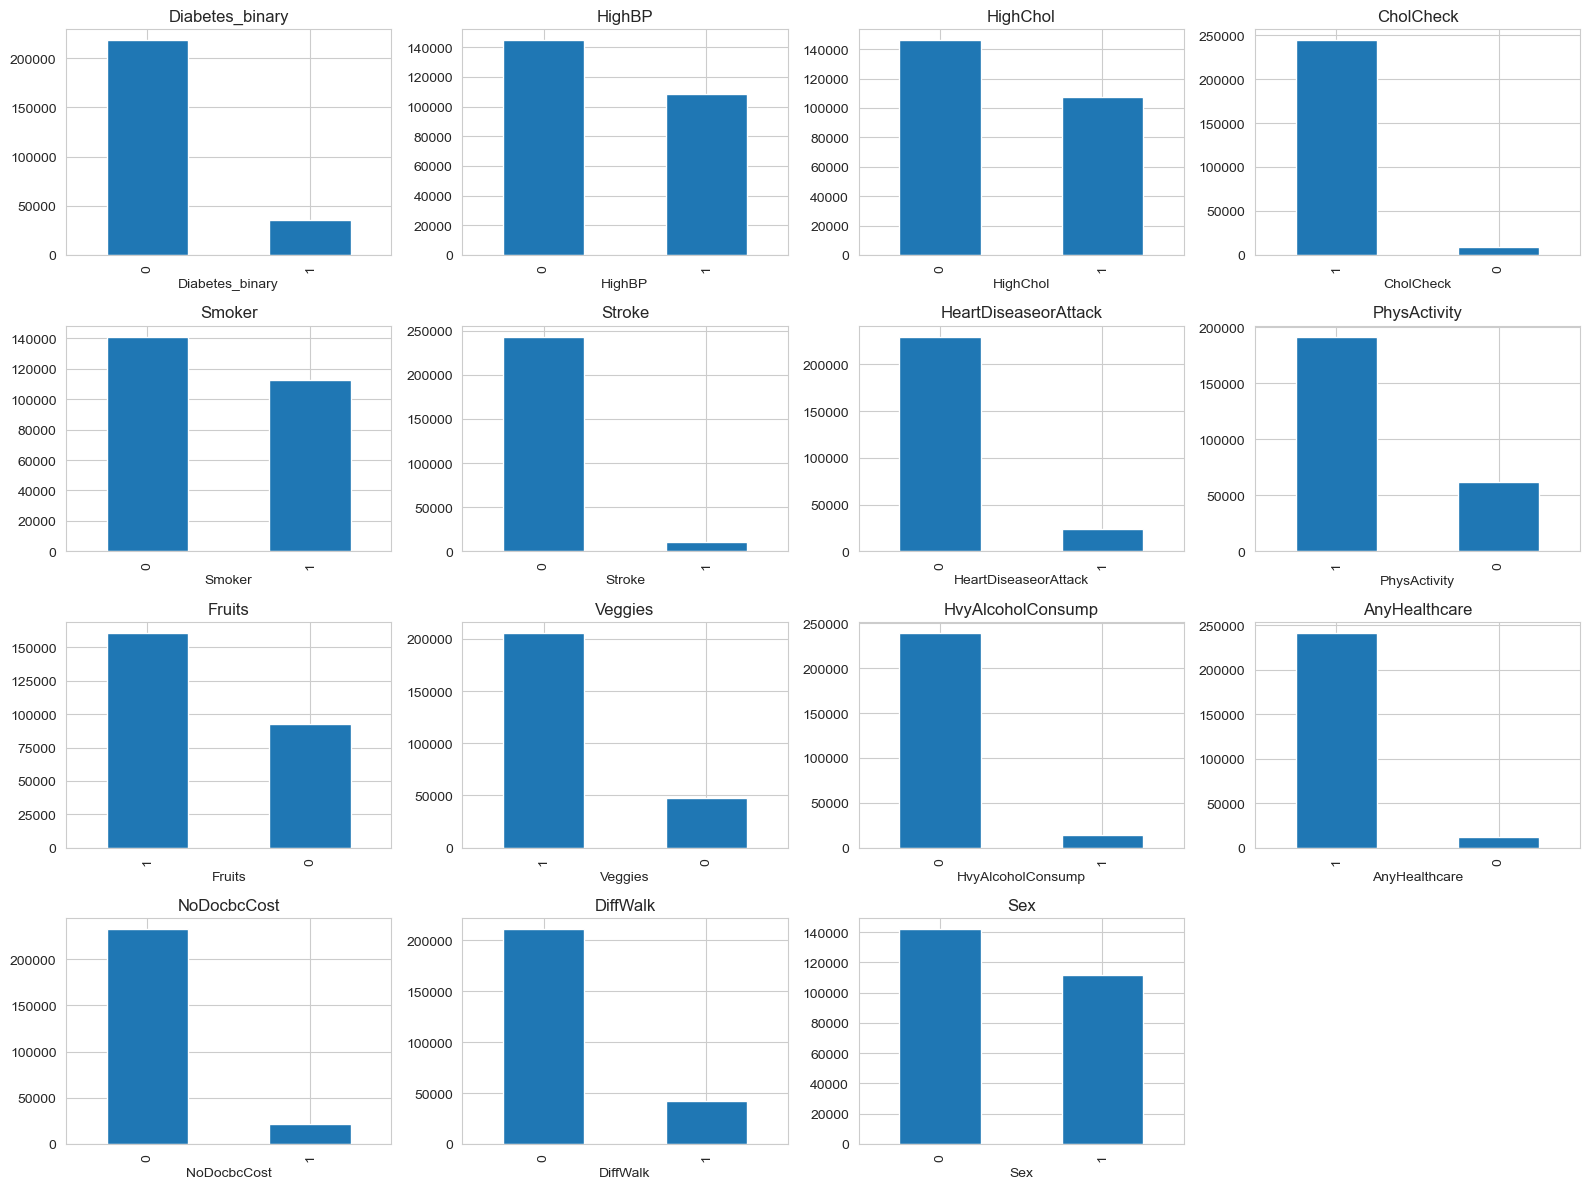

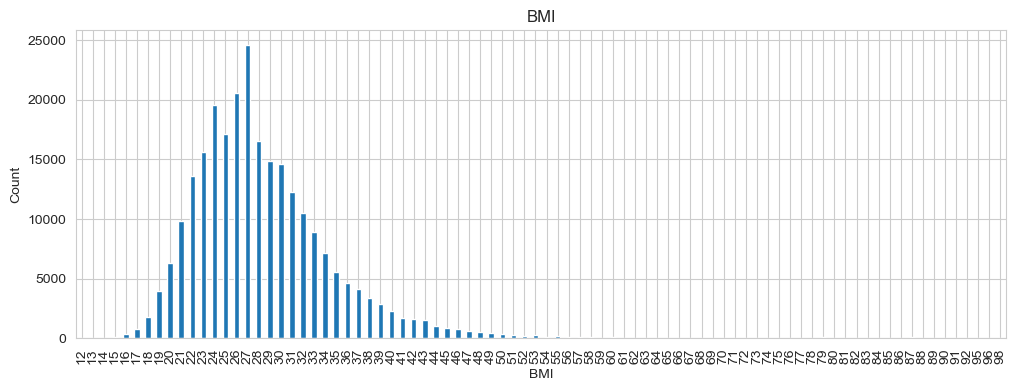

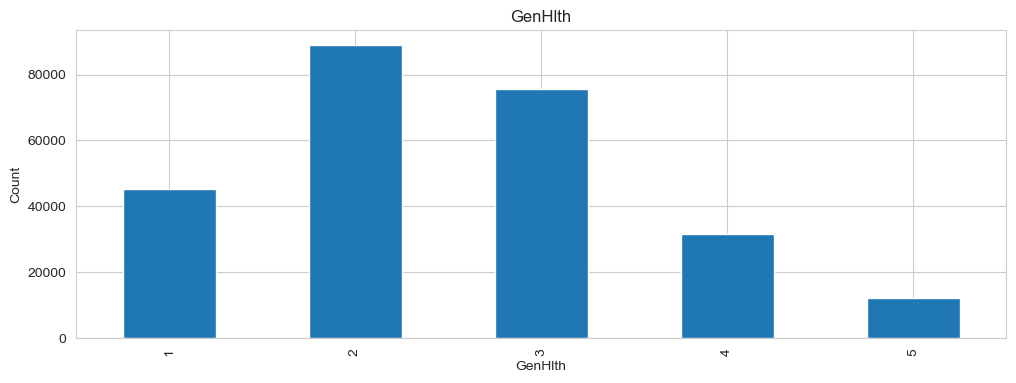

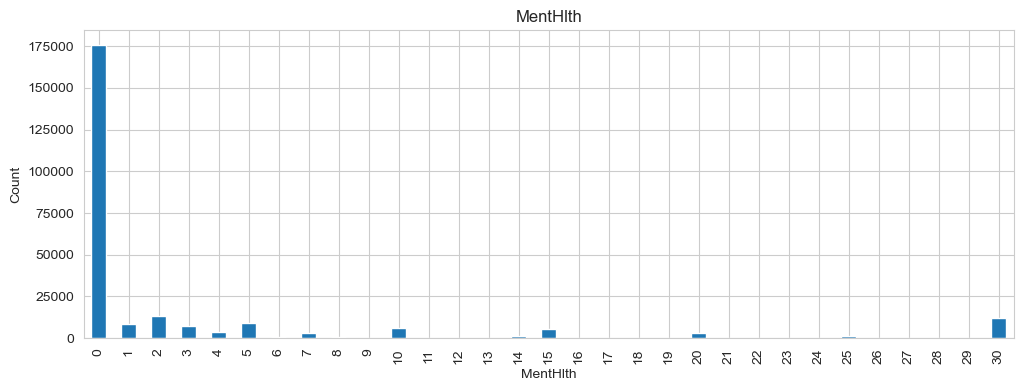

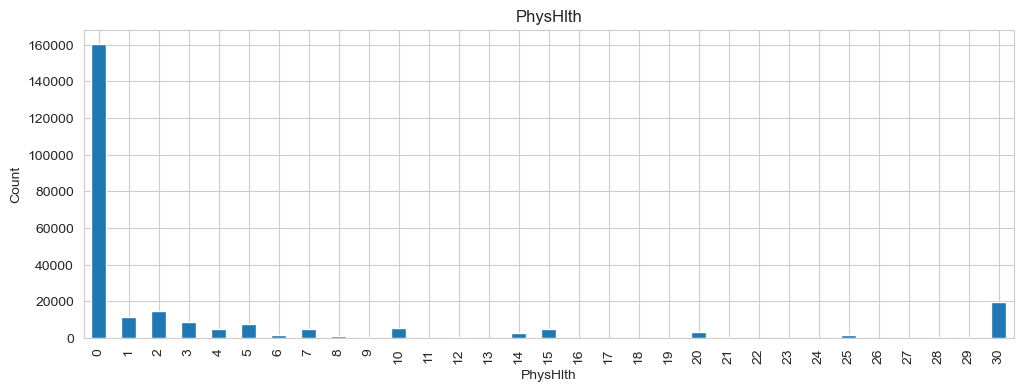

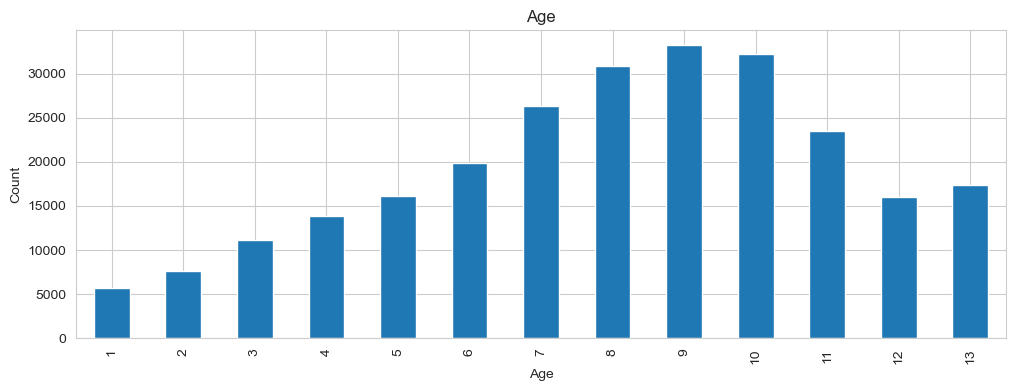

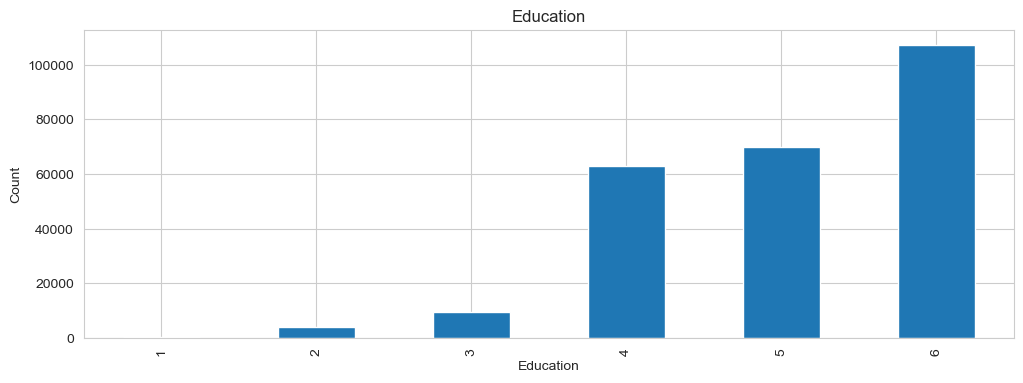

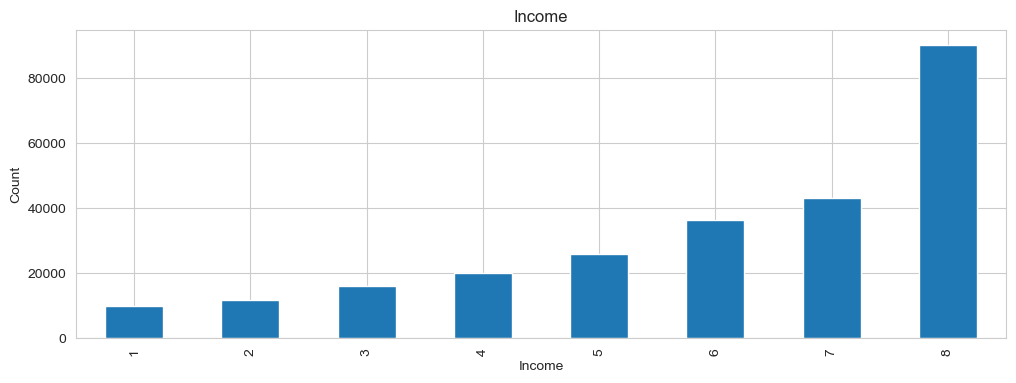

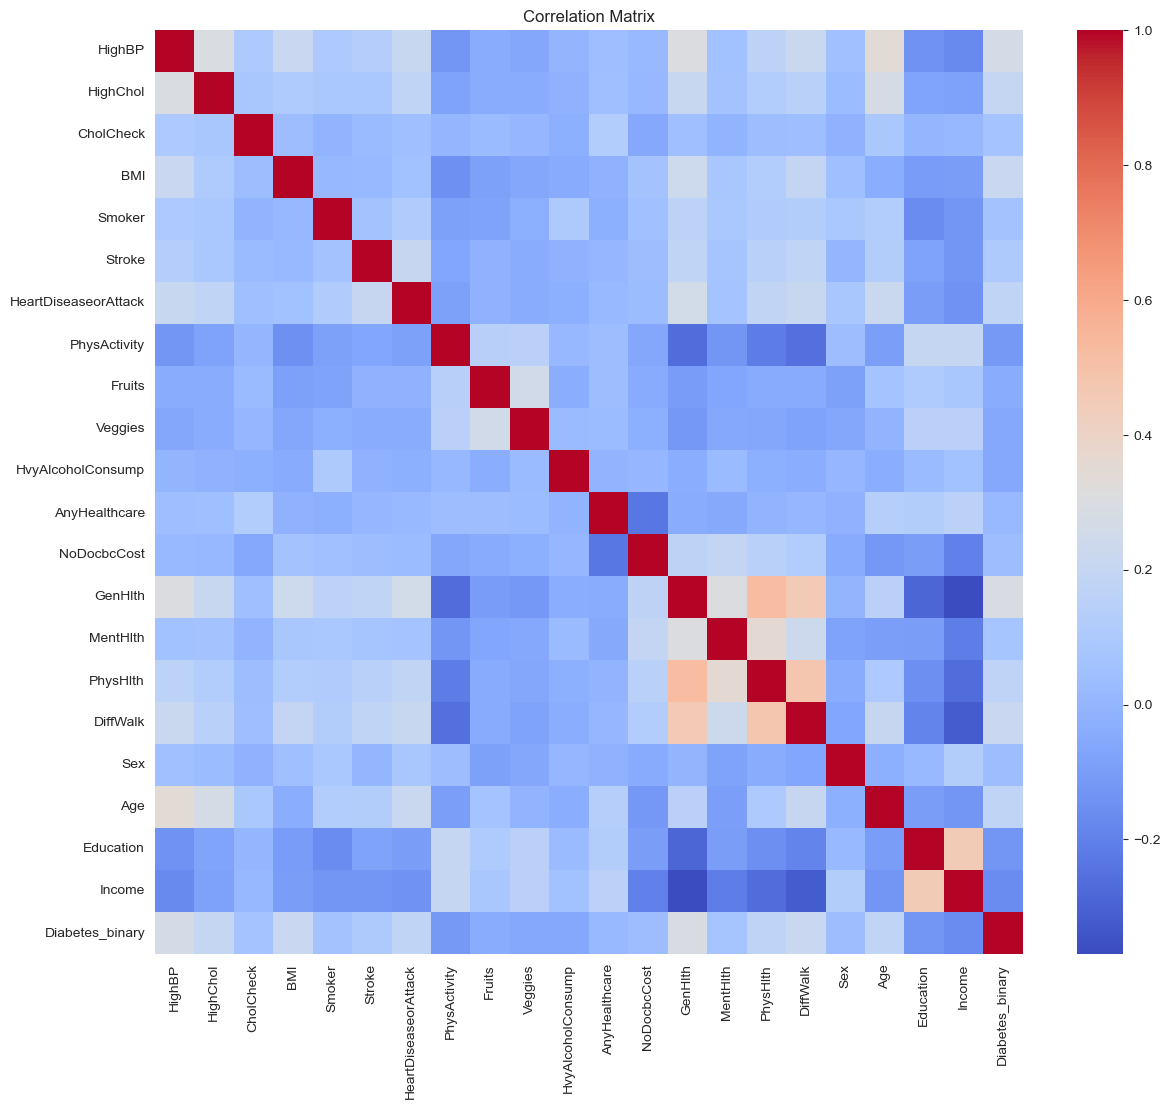

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("===== DATA SHAPE =====")
print(X_with_y.shape)

print("\n===== DATA INFO =====")
print(X_with_y.info())

print("\n===== MISSING VALUES =====")
print(X_with_y.isnull().sum())

print("\n===== VALUE RANGES =====")
for col in X_with_y.columns:
    print(f"{col}: min={X_with_y[col].min()}, max={X_with_y[col].max()}, unique={X_with_y[col].nunique()}")

binary_cols = [
    'Diabetes_binary','HighBP','HighChol','CholCheck','Smoker','Stroke',
    'HeartDiseaseorAttack','PhysActivity','Fruits','Veggies',
    'HvyAlcoholConsump','AnyHealthcare','NoDocbcCost','DiffWalk','Sex'
]

integer_cols = [
    'BMI','GenHlth','MentHlth','PhysHlth','Age','Education','Income'
]

id_cols = ['ID']

print("\n===== FEATURE GROUPS =====")
print("Binary features:", binary_cols)
print("Integer (ordered/categorical) features:", integer_cols)
print("ID columns:", id_cols)

plt.figure(figsize=(16, 12))
for i, col in enumerate(binary_cols, 1):
    plt.subplot(4, 4, i)
    X_with_y[col].value_counts().plot(kind="bar")
    plt.title(col)
plt.tight_layout()
plt.show()

for col in integer_cols:
    plt.figure(figsize=(12, 4))  # 每个特征一个 figure
    counts = X_with_y[col].value_counts(sort=False).sort_index()
    counts.plot(kind='bar')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

plt.figure(figsize=(14, 12))
sns.heatmap(X_with_y.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()

In [17]:
#Data cleaning (so it plays nice with pgmpy)
#convert BMI into underweight, normal, overweight, obese, and extremely obese (respectively 0 through 4)
X.loc[:, "BMI"] = pd.cut(
    X.loc[:, "BMI"],
    bins=[0, 18.5, 25, 30, 35, float("inf")],
    labels=[0, 1, 2, 3, 4]
).astype(int)

#shift age to be 0 through 12 instead of 1 through 13
X.loc[:, "Age"] = X.loc[:, "Age"] - 1

#shift education to be 0 through 5 instead of 1 through 6
X.loc[:, "Education"] = X.loc[:, "Education"] - 1

#shift income to be 0 through 7 instead of 1 through 8 
X.loc[:, "Income"] = X.loc[:, "Income"] - 1

# GenHlth: 1–5 → 0 ("good"), 1 ("average"), 2 ("poor")
X.loc[:, "GenHlth"] = pd.cut(
    X["GenHlth"],
    bins=[0, 2, 3, 5],       # (0,2], (2,3], (3,5]
    labels=[0, 1, 2]
).astype(int)

# MentHlth: 0–30 days → good / medium / poor
X.loc[:, "MentHlth"] = pd.cut(
    X["MentHlth"],
    bins=[-1, 5, 15, 30],    # (-1,5], (5,15], (15,30]
    labels=[0, 1, 2]
).astype(int)

# PhysHlth: 0–30 days → good / medium / poor
X.loc[:, "PhysHlth"] = pd.cut(
    X["PhysHlth"],
    bins=[-1, 5, 15, 30],
    labels=[0, 1, 2]
).astype(int)

X_with_y = X.copy()
X_with_y["Diabetes_binary"] = y.values

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HighBP': 'N', 'HighChol': 'N', 'CholCheck': 'N', 'BMI': 'N', 'Smoker': 'N', 'Stroke': 'N', 'HeartDiseaseorAttack': 'N', 'PhysActivity': 'N', 'Fruits': 'N', 'Veggies': 'N', 'HvyAlcoholConsump': 'N', 'AnyHealthcare': 'N', 'NoDocbcCost': 'N', 'GenHlth': 'N', 'MentHlth': 'N', 'PhysHlth': 'N', 'DiffWalk': 'N', 'Sex': 'N', 'Age': 'N', 'Education': 'N', 'Income': 'N', 'Diabetes_binary': 'N'}


Used 50000 samples to learn...


Working for n conditional variables: 5: 100%|██████████| 5/5 [24:09<00:00, 289.93s/it]

Learned edges:
[('Income', 'PhysActivity'), ('Income', 'Education'), ('HeartDiseaseorAttack', 'GenHlth'), ('GenHlth', 'PhysHlth'), ('GenHlth', 'Income'), ('GenHlth', 'DiffWalk'), ('GenHlth', 'BMI'), ('GenHlth', 'Education'), ('PhysHlth', 'MentHlth'), ('DiffWalk', 'BMI'), ('DiffWalk', 'Income'), ('Sex', 'BMI'), ('Sex', 'Education'), ('Sex', 'Income'), ('MentHlth', 'Income'), ('MentHlth', 'NoDocbcCost'), ('AnyHealthcare', 'Income'), ('AnyHealthcare', 'Education'), ('AnyHealthcare', 'Age'), ('NoDocbcCost', 'Education'), ('NoDocbcCost', 'Age'), ('NoDocbcCost', 'Income'), ('HighBP', 'BMI'), ('Smoker', 'Education'), ('Smoker', 'Age'), ('Diabetes_binary', 'BMI'), ('HighChol', 'BMI'), ('HighChol', 'HighBP'), ('HighChol', 'Age'), ('Veggies', 'Education'), ('CholCheck', 'Age')]
Learned 31 edges


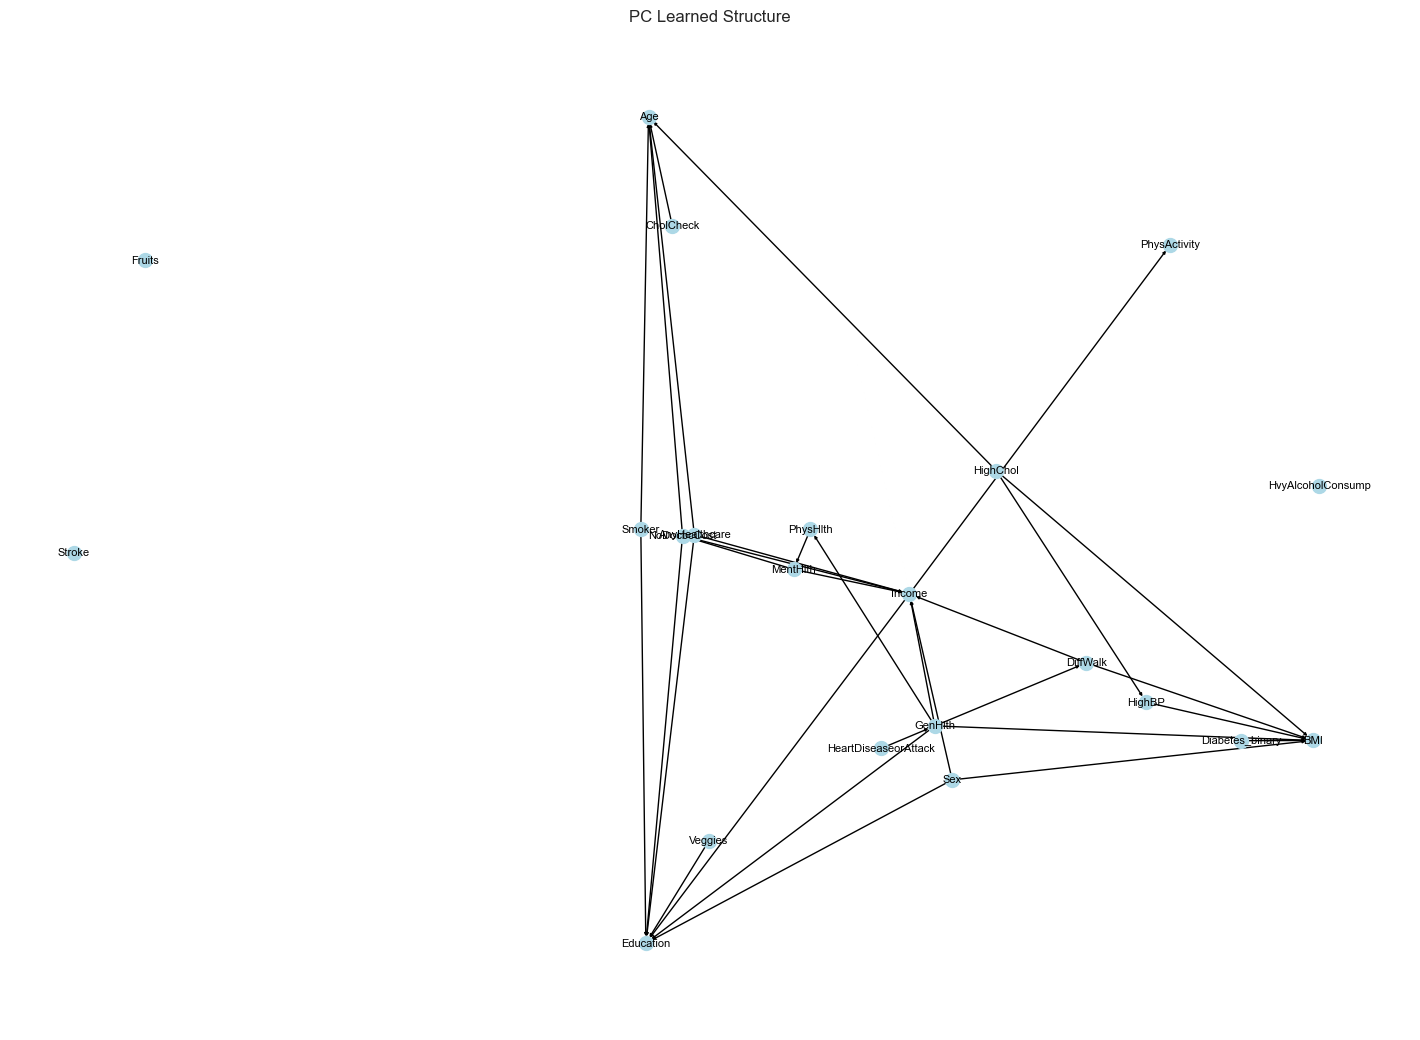

In [31]:
from pgmpy.estimators import PC
import networkx as nx
import matplotlib.pyplot as plt

subset_size = 50000
X_with_y_subset = X_with_y.head(subset_size)

print(f"Used {subset_size} samples to learn...")

pc = PC(data=X_with_y_subset)
estimated_model = pc.estimate(
    ci_test="chi_square", 
    significance_level=0.05,
    max_cond_vars=10,
    show_progress=True
)

===== DATA SHAPE =====
(253680, 22)

===== DATA INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253

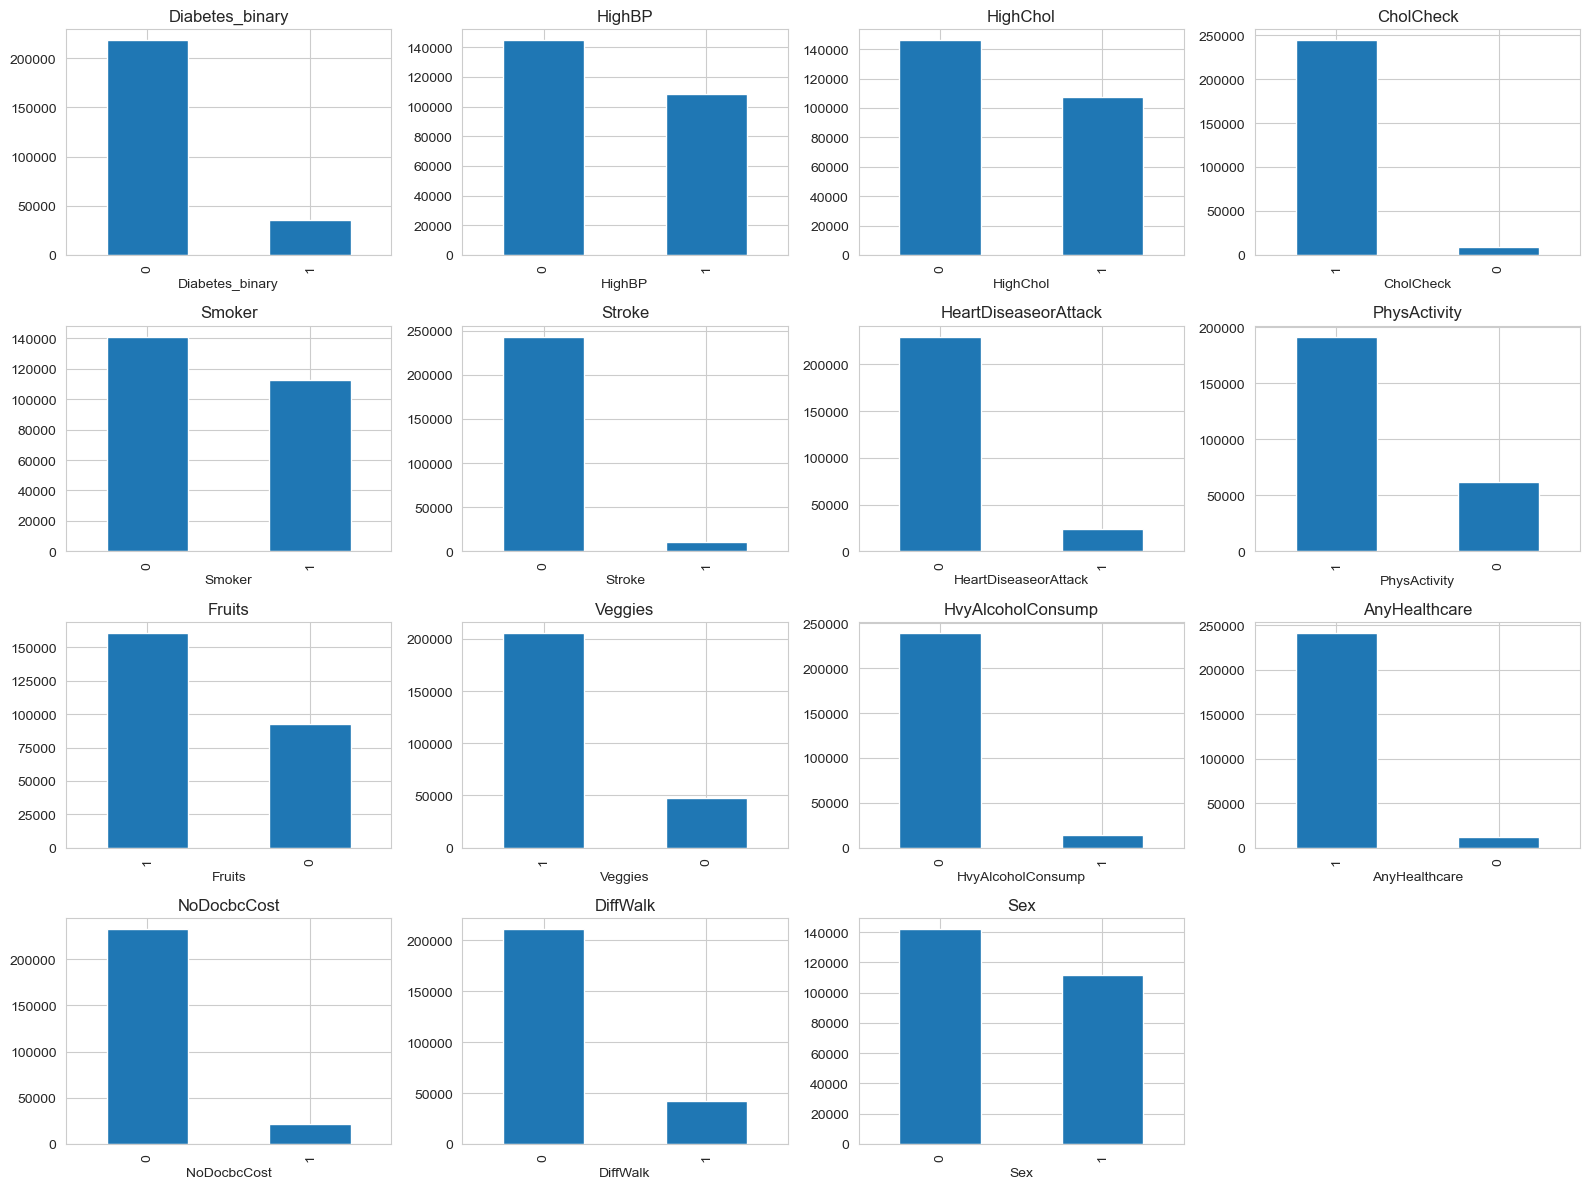

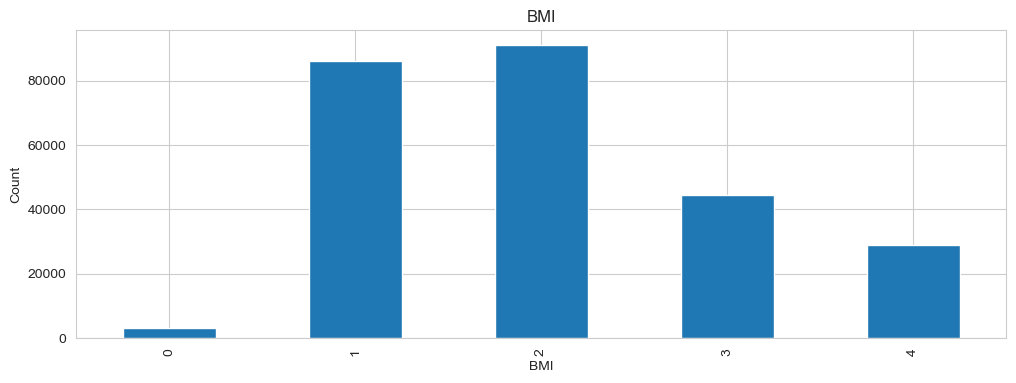

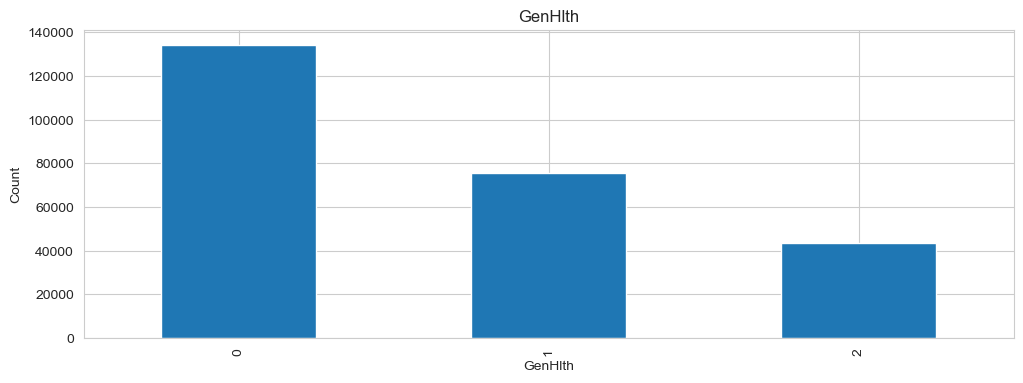

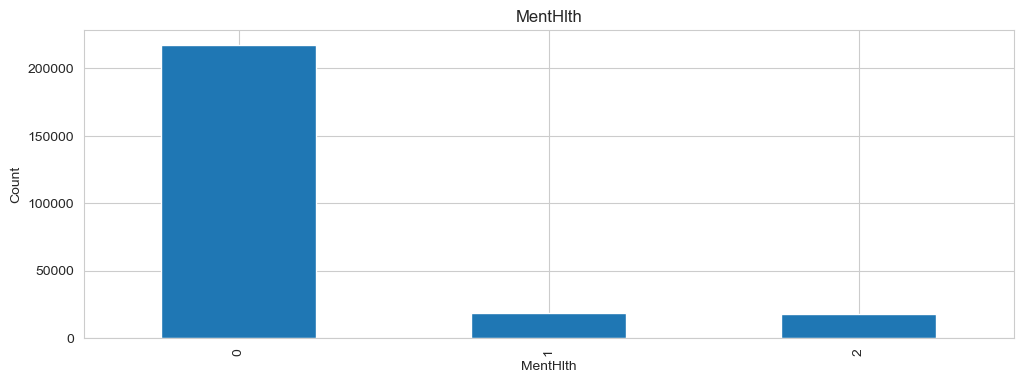

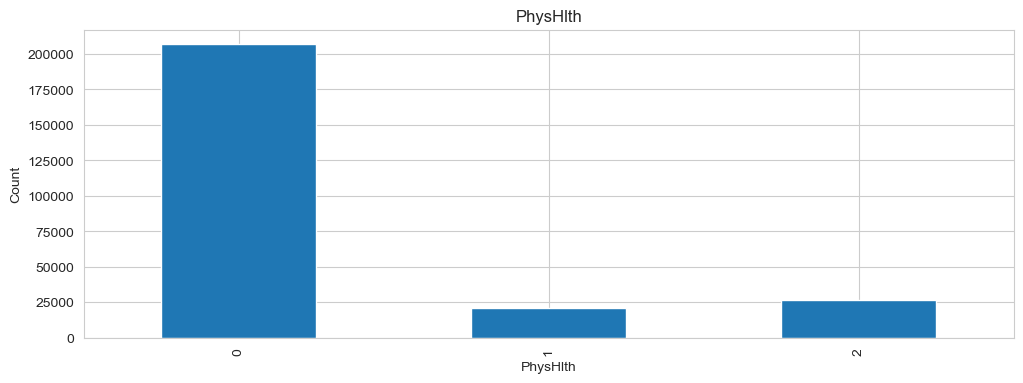

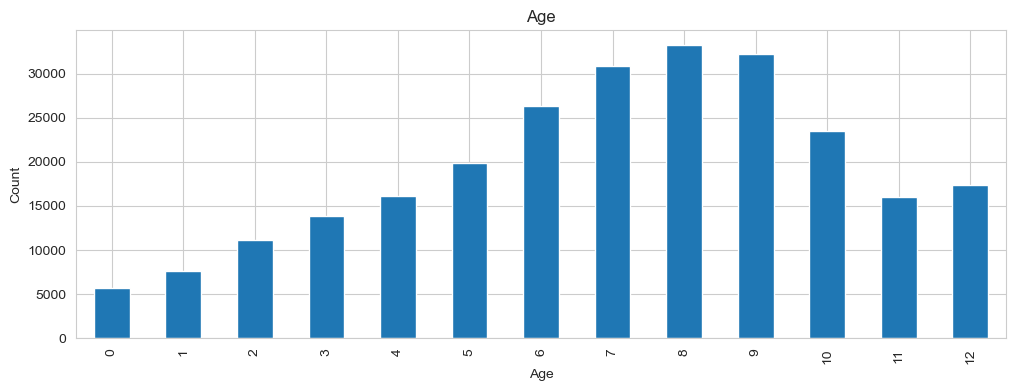

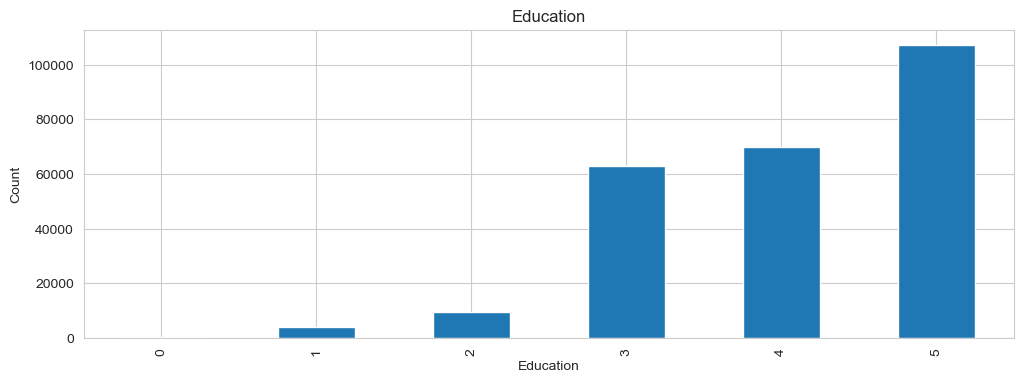

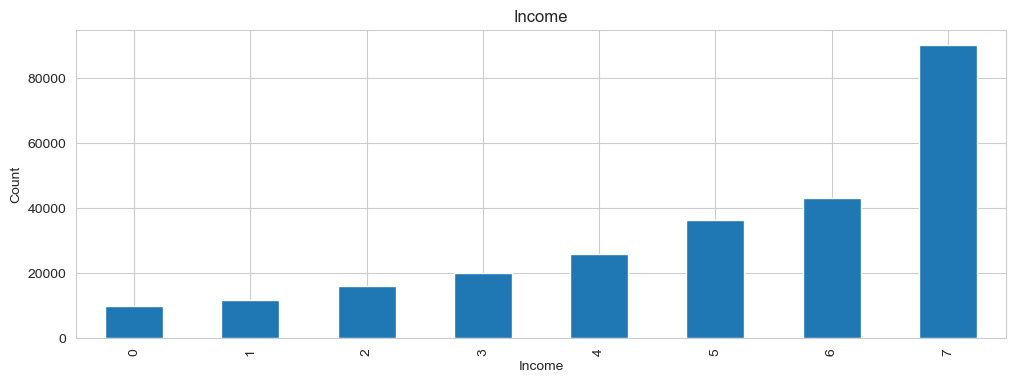

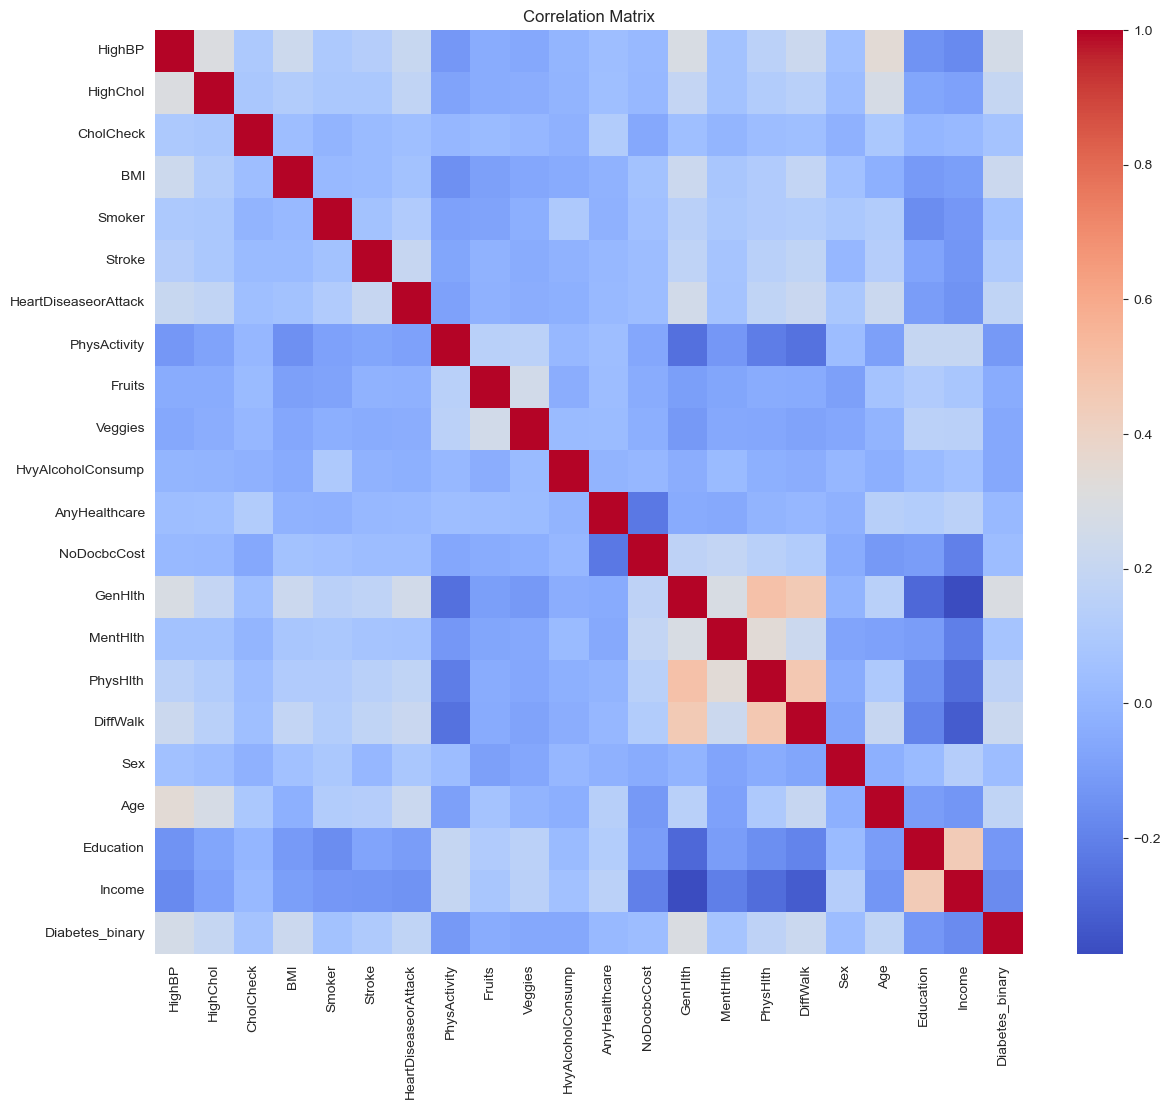

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("===== DATA SHAPE =====")
print(X_with_y.shape)

print("\n===== DATA INFO =====")
print(X_with_y.info())

print("\n===== MISSING VALUES =====")
print(X_with_y.isnull().sum())

print("\n===== VALUE RANGES =====")
for col in X_with_y.columns:
    print(f"{col}: min={X_with_y[col].min()}, max={X_with_y[col].max()}, unique={X_with_y[col].nunique()}")

binary_cols = [
    'Diabetes_binary','HighBP','HighChol','CholCheck','Smoker','Stroke',
    'HeartDiseaseorAttack','PhysActivity','Fruits','Veggies',
    'HvyAlcoholConsump','AnyHealthcare','NoDocbcCost','DiffWalk','Sex'
]

integer_cols = [
    'BMI','GenHlth','MentHlth','PhysHlth','Age','Education','Income'
]

id_cols = ['ID']

print("\n===== FEATURE GROUPS =====")
print("Binary features:", binary_cols)
print("Integer (ordered/categorical) features:", integer_cols)
print("ID columns:", id_cols)

plt.figure(figsize=(16, 12))
for i, col in enumerate(binary_cols, 1):
    plt.subplot(4, 4, i)
    X_with_y[col].value_counts().plot(kind="bar")
    plt.title(col)
plt.tight_layout()
plt.show()

for col in integer_cols:
    plt.figure(figsize=(12, 4))  # 每个特征一个 figure
    counts = X_with_y[col].value_counts(sort=False).sort_index()
    counts.plot(kind='bar')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

plt.figure(figsize=(14, 12))
sns.heatmap(X_with_y.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()

Learned edges:
[('Income', 'PhysActivity'), ('Income', 'Education'), ('HeartDiseaseorAttack', 'GenHlth'), ('GenHlth', 'PhysHlth'), ('GenHlth', 'Income'), ('GenHlth', 'DiffWalk'), ('GenHlth', 'BMI'), ('GenHlth', 'Education'), ('PhysHlth', 'MentHlth'), ('DiffWalk', 'BMI'), ('DiffWalk', 'Income'), ('Sex', 'BMI'), ('Sex', 'Education'), ('Sex', 'Income'), ('MentHlth', 'Income'), ('MentHlth', 'NoDocbcCost'), ('AnyHealthcare', 'Income'), ('AnyHealthcare', 'Education'), ('AnyHealthcare', 'Age'), ('NoDocbcCost', 'Education'), ('NoDocbcCost', 'Age'), ('NoDocbcCost', 'Income'), ('HighBP', 'BMI'), ('Smoker', 'Education'), ('Smoker', 'Age'), ('Diabetes_binary', 'BMI'), ('HighChol', 'BMI'), ('HighChol', 'HighBP'), ('HighChol', 'Age'), ('Veggies', 'Education'), ('CholCheck', 'Age')]
Learned 31 edges


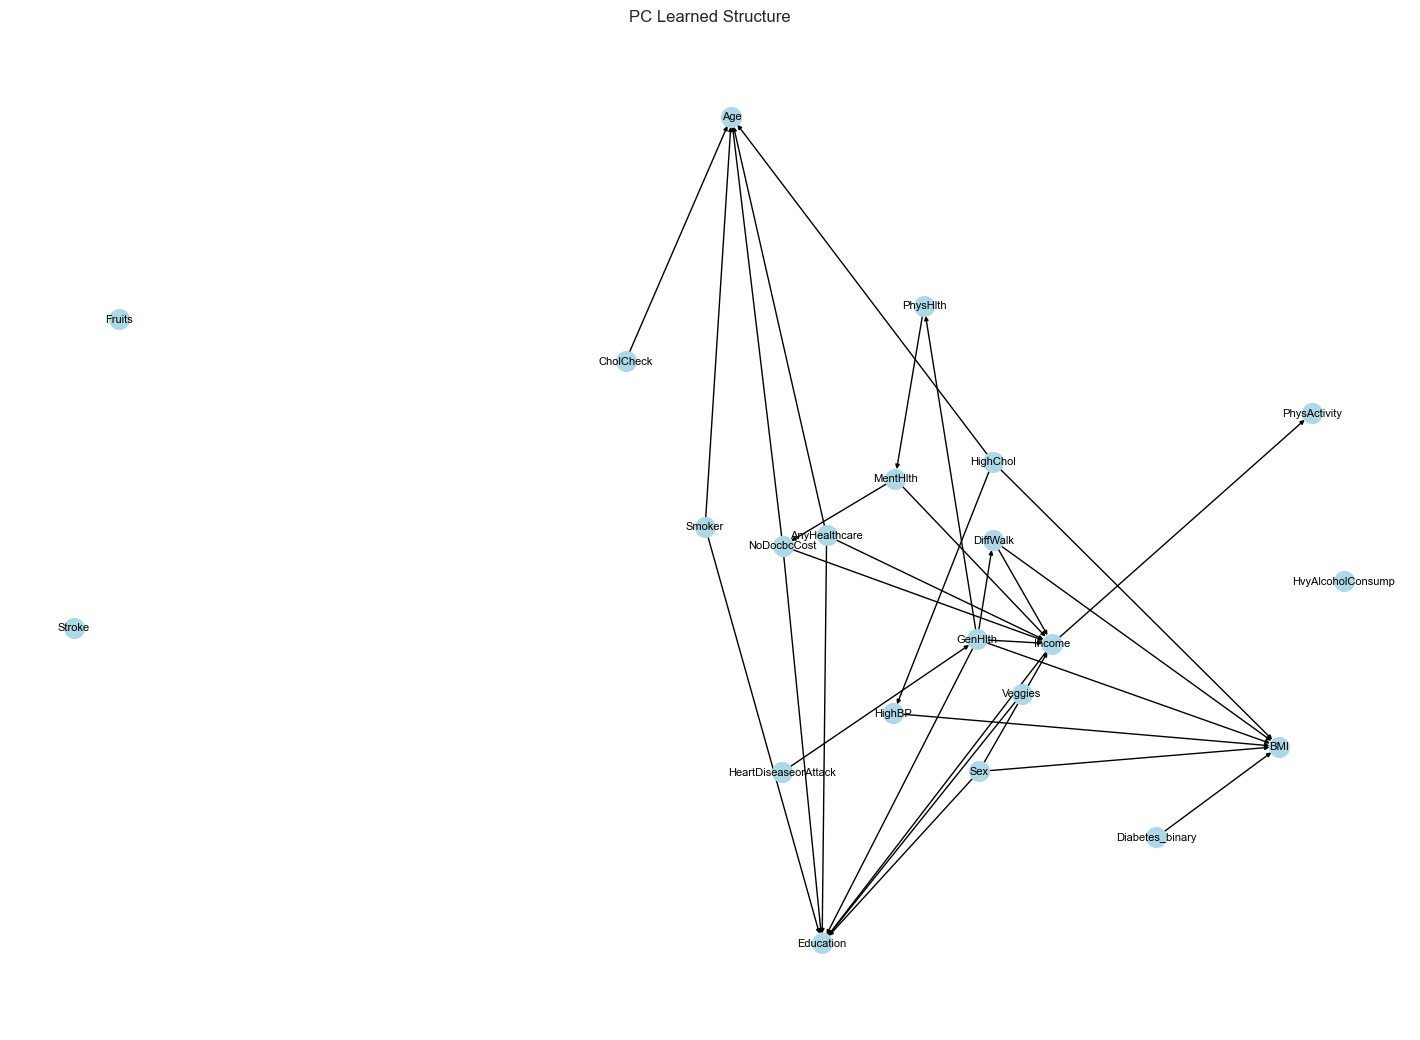

In [66]:
print("Learned edges:")
print(list(estimated_model.edges()))
print(f"Learned {len(estimated_model.edges())} edges")

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(
    estimated_model,
    seed=42,
    k=2,       
    iterations=210  
)

nx.draw(
    estimated_model,
    pos,
    with_labels=True,
    node_size=200,
    font_size=8,
    arrowsize=6,
    node_color='lightblue'
)
plt.title(f"PC Learned Structure")
plt.show()